In [1]:
import pandas as pd
import numpy as np


In [65]:
filepath = "train.csv"
df = pd.read_csv(filepath)

Drop FireplaceQu, PoolQC, Fence, MiscFeature, Alley

In [4]:
# old version
df = df.drop(['Alley'],axis=1)
df = df.drop(['PoolQC'],axis=1)
df = df.drop(['Fence'],axis=1)
df = df.drop(['FireplaceQu'],axis=1)

In [66]:
# new version
df = df.drop(['PoolQC'],axis=1)
df = df.drop(['FireplaceQu'],axis=1)
df = df.drop(['MiscFeature'],axis=1)

Label encoding

In [67]:
df = df.fillna(df.mean())
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [5]:
!pip install xgboost

mkl-random 1.0.1 requires cython, which is not installed.
tensorflow 1.11.0 has requirement setuptools<=39.1.0, but you'll have setuptools 40.4.3 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [68]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df = df.apply(preprocessing.LabelEncoder().fit_transform)


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
y = df['SalePrice']
X = df.drop(['SalePrice'],axis=1)
train_X, test_X, train_y, test_y = train_test_split(X.values,y.values, test_size=.2)

In [70]:
import xgboost as xgb
my_model= xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)

In [71]:
my_model.fit(train_X, train_y, early_stopping_rounds=5, eval_set=[(test_X, test_y)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [80]:
#testing where the largest error is
err_marg = 210
for i in range (0,292):
    if (abs(test_y[i] - predictions[i])>err_marg):
        print(i)


95


In [78]:
print("test is",test_y[62]," and prediction ",predictions[62])
abs(test_y[62] - predictions[62])>180

test is 103  and prediction  147.21167


False

In [73]:
# make predictions to evaluate
# standard, no tuning -> 35.98 & 2334.3
# n_est = 1000, early_stopping_round = 5 -> 35.6 & 2290.3
# n_est = 1000, early_stopping_round = 5, learning_rate = 0.05 -> 35.3 & 2235.4
predictions = my_model.predict(test_X)
# mean absolute error
from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error : ' + str(mean_absolute_error(predictions, test_y)))
# mean squared error
from sklearn.metrics import mean_squared_error
print('Mean Squared Error: ' + str(mean_squared_error(predictions, test_y)))

Mean Absolute Error : 32.47490344308827
Mean Squared Error: 2086.430700590881


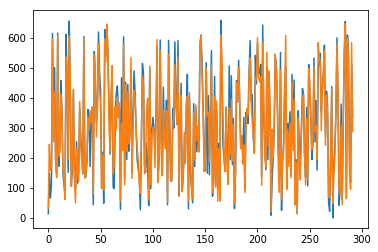

In [74]:
import matplotlib.pyplot  as plt
plt.plot(test_y)
plt.plot(predictions)
plt.show()

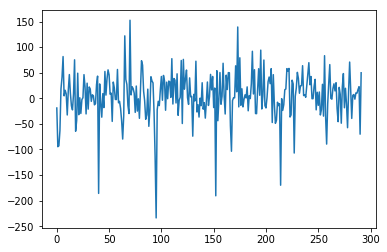

In [75]:
plt.plot((test_y - predictions))
plt.show()